<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻 01 - OAKD basic integration

In [51]:
%matplotlib inline

import os
import sys
import time
import yaml
import rospy
import numpy as np
import cv2
from typing import List, Dict, Callable, Optional, Any

from sensor_msgs.msg import CompressedImage, Image

import depthai as dai

## Creating a pipeline

The "pipeline" is an object documented in the [`depthai` API](https://docs.luxonis.com/projects/api/en/latest/) and can be initialized as follows:

In [17]:
def create_pipeline() -> dai.Pipeline:
    pipeline = dai.Pipeline()
    pipeline.setOpenVINOVersion(version=dai.OpenVINO.Version.VERSION_2021_3)
    return pipeline

## Creating and configuring nodes

"Nodes" (not ROS nodes) are different types of sensing modalities of the OAK-D. For example: images, stereo, or neural networks. They are configured using a "pipeline" object as a reference, which tracks all of the nodes that get created and pass them onto the OAK-D hardware to configure the device internally once the structure is defined.

In [37]:
def create_nodes(pipeline: dai.Pipeline) -> Dict[str, dai.Node]:
    # LEFT CAMERA
    cam_left = pipeline.createMonoCamera()
    cam_left.setBoardSocket(dai.CameraBoardSocket.LEFT)
    cam_left.setResolution(
        dai.MonoCameraProperties.SensorResolution.THE_400_P)

    # RIGHT CAMERA
    cam_right = pipeline.createMonoCamera()
    cam_right.setBoardSocket(dai.CameraBoardSocket.RIGHT)
    cam_right.setResolution(
        dai.MonoCameraProperties.SensorResolution.THE_400_P)

    # RGB CAMERA
    cam_rgb = pipeline.createColorCamera()
    cam_rgb.setBoardSocket(dai.CameraBoardSocket.RGB)
    cam_rgb.setResolution(
        dai.ColorCameraProperties.SensorResolution.THE_1080_P)
    cam_rgb.setColorOrder(
        dai.ColorCameraProperties.ColorOrder.RGB)
    cam_rgb.setInterleaved(False)
    cam_rgb.setPreviewSize(640, 400)

    # STEREO
    stereo = pipeline.createStereoDepth()
    stereo.setConfidenceThreshold(150)
    stereo.setMedianFilter(
        dai.StereoDepthProperties.MedianFilter.KERNEL_7x7)
    stereo.setLeftRightCheck(False)
    stereo.setExtendedDisparity(False)  # True = better for short-range
    stereo.setSubpixel(False)  # True = better for long-range
    stereo.setRectifyMirrorFrame(False)

    return {
        'left': cam_left,
        'right': cam_right,
        'rgb': cam_rgb,
        'stereo': stereo
    }

## Outputs

Output links are [a special type of node](https://docs.luxonis.com/projects/api/en/latest/components/nodes/xlink_out/) which exist at the interface of the OAK-D hardware and the interface of your computer or Duckiebot. They provide a way to access the data perceived by the OAK-D.

In [38]:
def create_output_links(pipeline: dai.Pipeline) -> Dict[str, dai.XLinkOut]:
    xout_links = {
        'left': pipeline.createXLinkOut(),
        'right': pipeline.createXLinkOut(),
        'rgb': pipeline.createXLinkOut(),
        'disparity': pipeline.createXLinkOut()
    }
    for name, xout_link in xout_links.items():
        xout_link.setStreamName(name)
        xout_link.input.setBlocking(False)
    return xout_links

## Linking nodes to each other

The various inputs and outputs of nodes need to be linked together to define the data flow, i.e. _what_ goes _where_? This will be tracked internally by the "pipeline" object and later used to configure the OAK-D device. For example, for a stereo node we need to define the two input images. For the output nodes, they need to know which "upstream" node in the computational graph they should be receiving data from.

In [39]:
def link_nodes_and_outputs(nodes: Dict[str, dai.Node],
                           outputs: Dict[str, dai.XLinkOut]) -> None:
    # Raw RGB image --> Image manipulation module
    nodes['rgb'].preview.link(outputs['rgb'].input)
    # Disparity --> link the raw left & right images as input to stereo
    nodes['left'].out.link(nodes['stereo'].left)
    nodes['right'].out.link(nodes['stereo'].right)
    nodes['stereo'].disparity.link(outputs['disparity'].input)
    nodes['stereo'].rectifiedLeft.link(outputs['left'].input)
    nodes['stereo'].rectifiedRight.link(outputs['right'].input)

## Creating a device

Once all of the nodes are initialized, configured, and properly linked together, the device can be created. The computer or Duckiebot will try to search for an OAK-D device using the `depthai` library and to configure the hardware using our "pipeline" object.

In [40]:
def create_device(pipeline: dai.Pipeline) -> dai.Device:
    device = dai.Device(pipeline, usb2Mode=False)
    device.setLogLevel(dai.LogLevel.DEBUG)
    return device

## Output queues

Remember those special "output links"? In order to read them, we need to initialize some "output queues" which will link to those outputs on the computer or Duckiebot side of things.

If a queue is "blocking", when a queue is full, any new incoming data will be dropped from the queue until the first item is read (popped) from the queue and a new space gets freed up. In contrast, a non-blocking queue will always insert new incoming data into the queue, and if the queue is filled up, the oldest data will get dropped.

In [41]:
def create_output_queues(device: dai.Device,
                         outputs: Dict[str, dai.XLinkOut]) -> Dict[str, dai.DataOutputQueue]:
    queues = dict()
    for name, xout_link in outputs.items():
        queues[name] = device.getOutputQueue(name=name, maxSize=1, blocking=False)
    return queues

## Reading data

With everything set up, let's create a utility function to read some specific requested data from the OAK-D, and return it in a dictionary mapping from the data name to the raw data (e.g. a Numpy array containing image data).

In [42]:
def read_data(requested_data: List[str],
              output_queues: Dict[str, dai.DataOutputQueue]) -> Dict[str, Any]:
    data = {name: None for name in requested_data}
    for name in requested_data:
        if name not in output_queues.keys():
            continue
        if name in ('left', 'right', 'rgb'):
            data[name] = output_queues[name].get().getCvFrame()
        elif name == 'disparity':
            data[name] = output_queues[name].get().getFrame()
    return data

## Test and visualize

Here is a simple helper function which uses the functions we've written to set up the OAK-D, continuously read data, and visualize it. This function optionally includes an "image processing" function which post-processes the data that we will read. This will come in handy for visualizing disparity data.

In [63]:
from IPython.display import display, Image

ImageProcFunc = Callable[[np.ndarray], np.ndarray]

def hello_oakd(output_name: str,
               im_proc: Optional[ImageProcFunc]=None) -> None:
    display_handle = display(None, display_id=True)
    pipeline = create_pipeline()
    nodes = create_nodes(pipeline)
    outputs = create_output_links(pipeline)
    link_nodes_and_outputs(nodes, outputs)
    device = create_device(pipeline)
    output_queues = create_output_queues(device, outputs)
    try:
        while True:
            data = read_data([output_name], output_queues)
            if output_name in data.keys():
                frame = data[output_name]
                if im_proc is not None:
                    frame = im_proc(frame)
                _, frame = cv2.imencode('.jpeg', frame)
                display_handle.update(Image(data=frame.tostring()))
    except KeyboardInterrupt:
        pass
    finally:
        pass
        # display_handle.update(None)

# Test it!

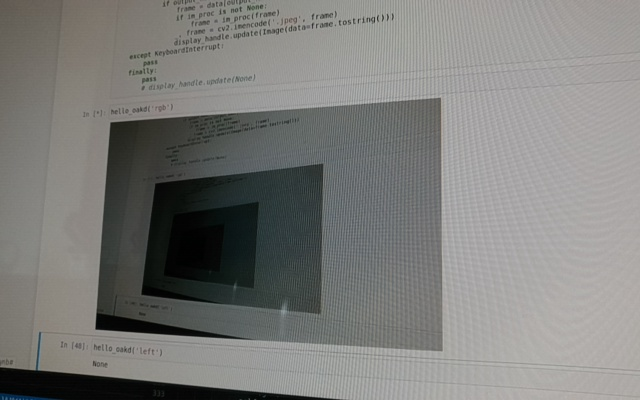

In [59]:
hello_oakd('rgb')

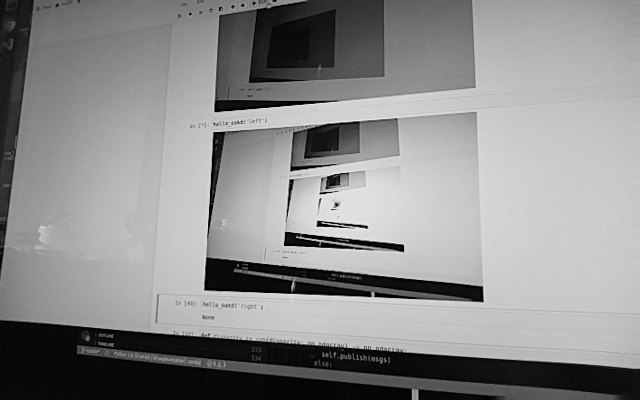

In [60]:
hello_oakd('left')

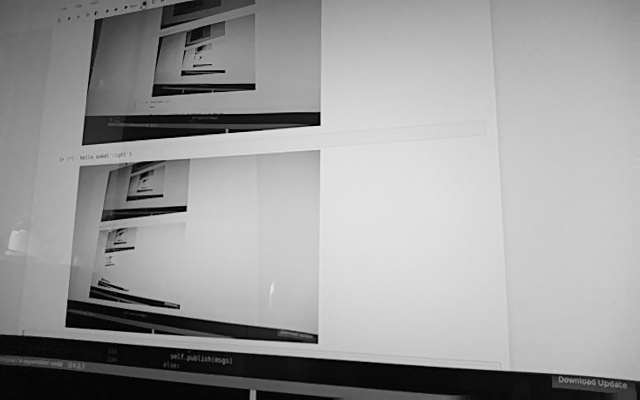

In [61]:
hello_oakd('right')

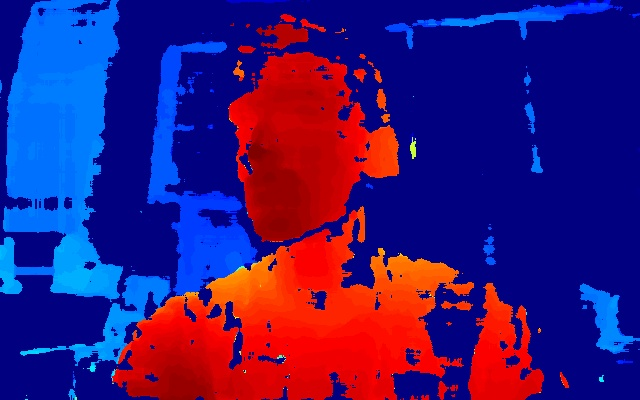

In [62]:
def disparity_to_rgb(disparity: np.ndarray) -> np.ndarray:
    norm = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    colored = cv2.applyColorMap(norm, cv2.COLORMAP_JET)
    return colored

hello_oakd('disparity', im_proc=disparity_to_rgb)